In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from impyute.imputation.cs import mice, fast_knn
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import tensorflow.keras.losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from boruta import BorutaPy

import pygad
import pygad.kerasga

In [2]:
def timestamp_data_treatment(dataset, category='numeric'):
    if category == 'binary':
        for column in ['Mes', 'Hora Medicao']:
            date = dataset[column]
            _max = date.max()
            i = 0
            while 2**i < _max:
                i += 1
            binary_rep = [np.binary_repr(z,width=i) for z in date.astype('int')]
            d = []
            for k in range(i):
                d.append(np.array([int(v) for s in binary_rep for v in s[k]]))
            t = np.vstack((d)).T
            if column == 'Mes':
                df_mes = pd.DataFrame(t, columns= [f'Mes_Bit_{ind}' for ind in range(i)])
            else:
                df_hora = pd.DataFrame(t, columns= [f'Hora_Bit_{ind}' for ind in range(i)])

    elif category == '1ofN':
        for column in ['Mes','Hora Medicao']:
            one_hot = pd.get_dummies(dataset[column])
            listoflists = one_hot.values.tolist()
            new_list = []
            for lists in listoflists:
                new_list.append(''.join(map(str, lists)))
            d = []
            if column == 'Mes':
                for k in range(12):
                        d.append(np.array([int(v) for s in new_list for v in s[k]]))
                t = np.vstack((d)).T
                df_mes = pd.DataFrame(t, columns= ['Jan', 'Fev', 'Mar','Abr','Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
            if column == 'Hora Medicao':
                for k in range(24):
                        d.append(np.array([int(v) for s in new_list for v in s[k]]))
                t = np.vstack((d)).T
                df_hora = pd.DataFrame(t, columns= [f'{ind} h' for ind in range(24)])
    
    elif category == 'numeric':
        for column in ['Mes','Hora Medicao']:
            _values = dataset[column].values
            _max = dataset[column].max()
            
            _array = np.array([float(i/_max) for i in _values])
            if column == 'Mes':
                df_mes = pd.DataFrame(_array, columns= ['Mes'])
            else:
                df_hora = pd.DataFrame(_array, columns= ['Horas'])
    else:
        print('Invalid Category, please select another one...')

    return df_mes, df_hora    


def preparing_data(dataset, features = [], lag = 24, normalize = 'minmax', category = 'binary', onlyHour = False, onlyMonth = False):
    _max = dataset.iloc[:,-1:].max().values
    _min = dataset.iloc[:,-1:].min().values
    _med = dataset.iloc[:,-1:].mean().values
    _std = dataset.iloc[:,-1:].std().values
    if normalize == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset_norm = scaler.fit_transform(dataset.drop([i for i in dataset.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']],axis=1))
        dataset_norm = pd.DataFrame(dataset_norm, 
                                   columns = dataset.drop([i for i in dataset.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']],axis=1).columns)
    elif normalize == 'standard':
        scaler = StandardScaler()
        dataset_norm = scaler.fit_transform(dataset.drop([i for i in dataset.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']],axis=1))
        dataset_norm = pd.DataFrame(dataset_norm, 
                                    columns = dataset.drop([i for i in dataset.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']],axis=1).columns)
    else:
        print('Invalid Category, please select another one...')
     
    X, Y = look_back_function(dataset_norm['VENTO, VELOCIDADE HORARIA(m/s)'],lag)
#     trend = pd.DataFrame(X.iloc[:, -1] - X.iloc[:, -2], columns = ['Trend'])
#     X = pd.concat([trend, X], axis = 1)
    mes, hora = timestamp_data_treatment(dataset, category)
    
    if len(features):
        for feature in features:
            if feature in dataset_norm.drop([i for i in dataset_norm.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']], axis=1).columns:
                X = pd.concat([dataset_norm[feature][lag:-1].reset_index(drop=True), X], axis=1)
        
    if onlyMonth:
        _input = pd.concat([mes[lag:-1].reset_index(drop=True), X], axis=1)
        
    elif onlyHour:
        _input = pd.concat([hora[lag:-1].reset_index(drop=True), X], axis=1)
        
    else:
        _input = pd.concat([mes[lag:-1].reset_index(drop=True), hora[lag:-1].reset_index(drop=True), X], axis=1)
        
    return _input, Y,_max, _min, _med, _std
        

def look_back_function (dataset, look_back=24):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    X = pd.DataFrame(np.array(dataX), columns = [f'X(t-{ind})' for ind in reversed(range(look_back))])
    Y = pd.DataFrame(np.array(dataY), columns=['Output'])
    return X, Y


def multistep_prediction(model, Input, lag):
    other_features = Input.iloc[:, :(Input.shape[1]-lag)]
    other_features_array = other_features.values

    wind_feature = Input.iloc[:,-lag:]
    wind_feature_array = wind_feature.values

    for i in range(len(wind_feature_array)):
        if i==0:
            x_multistep = np.concatenate((other_features_array[i],wind_feature_array[i]))
            _y_hat = model.predict(x_multistep.reshape(1,-1))
            predict_array = np.array(_y_hat)
        else:
            if i < lag:
                wind_array_copy =  wind_feature_array[i, :]
                wind_array_copy = wind_array_copy[:-predict_array.shape[0]]
                data_array_with_prediction = np.insert(wind_array_copy,wind_array_copy.size,predict_array)
            else:
                data_array_with_prediction = predict_array[-lag:]
            x_multistep = np.concatenate((other_features_array[i],data_array_with_prediction))
            _y_hat = model.predict(x_multistep.reshape(1,-1))
            predict_array = np.append(predict_array, _y_hat)
    predict_data = pd.DataFrame(predict_array, columns=['Predictions'])
    return predict_data

def mask_classification(raw_data):
    classification_list = np.array([])
    for idx, x in raw_data.iterrows():
        if 0 <= x.values <= 4:
            classification_list = np.append(classification_list, 1)
        elif 4 < x.values <= 10:
            classification_list = np.append(classification_list, 2)
        elif 10 < x.values <= 15:
            classification_list = np.append(classification_list, 3)
        elif 15 < x.values <= 25:
            classification_list = np.append(classification_list, 4)
        else:
            classification_list = np.append(classification_list, 5)
    return classification_list

def MAPE(testY, testPredict):
    soma, cont = 0, 0
    for idx, value in testY.iterrows():
        if abs(value.values) >= 0.01:
            erro = abs((value - testPredict.values[idx])/value)
            soma += erro
            cont += 1
    mape = (soma/cont)*100
    return mape

In [3]:
df_train_micetreated = pd.read_csv('Treino_Arraial_do_Cabo_MICE.csv', sep = ';')
df_test_micetreated = pd.read_csv('Teste_Arraial_do_Cabo_MICE.csv', sep = ';')

In [4]:
df = pd.concat([df_train_micetreated, df_test_micetreated])
df = df.drop([i for i in df.columns if i in 
              ['Dia', 'Mes', 'Ano', 'Hora Medicao', 'TEMPERATURA DA CPU DA ESTACAO(°C)', 'TENSAO DA BATERIA DA ESTACAO(V)']],axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
df_norm = scaler.fit_transform(df)
df_norm = pd.DataFrame(df_norm, columns = df.columns)

**Seleção de Features**

In [5]:
#Backward Elimination
_x = df_norm.drop([i for i in df_norm.columns if i in ['VENTO, VELOCIDADE HORARIA(m/s)']],axis=1)
X_1 = sm.add_constant(_x)
_y = df_norm["VENTO, VELOCIDADE HORARIA(m/s)"]
model = sm.OLS(_y,X_1).fit()
model.pvalues

cols = list(_x.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = _x[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(_y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['PRECIPITACAO TOTAL, HORARIO(mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)', 'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)', 'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)', 'RADIACAO GLOBAL(Kj/m�)', 'TEMPERATURA DA CPU DA ESTACAO(�C)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(�C)', 'TEMPERATURA DO PONTO DE ORVALHO(�C)', 'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(�C)', 'TEMPERATURA MINIMA NA HORA ANT. (AUT)(�C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(�C)', 'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(�C)', 'UMIDADE RELATIVA DO AR, HORARIA(%)', 'VENTO, DIRECAO HORARIA (gr)(� (gr))', 'VENTO, RAJADA MAXIMA(m/s)']


In [12]:
#RFE
nof_list=np.arange(1,df_norm.shape[1])            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(_x,_y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

print(df_norm.shape[1])
cols = list(_x.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(_x,_y)  
#Fitting the data to model
model.fit(X_rfe,_y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

c:\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (re

Optimum number of features: 16
Score with 16 features: 0.853087
19
Index(['PRECIPITACAO TOTAL, HORARIO(mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)',
       'PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)',
       'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)',
       'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)',
       'RADIACAO GLOBAL(Kj/m�)', 'TEMPERATURA DA CPU DA ESTACAO(�C)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA(�C)',
       'TEMPERATURA DO PONTO DE ORVALHO(�C)',
       'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(�C)',
       'TEMPERATURA MINIMA NA HORA ANT. (AUT)(�C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(�C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(�C)',
       'UMIDADE RELATIVA DO AR, HORARIA(%)',
       'VENTO, DIRECAO HORARIA (gr)(� (gr))', 'VENTO, RAJADA MAXIMA(m/s)'],
      dtype='object')


c:\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=16 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Best alpha using built-in LassoCV: 0.000016
Best score using built-in LassoCV: 0.852889
['PRECIPITACAO TOTAL, HORARIO(mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)', 'RADIACAO GLOBAL(Kj/m�)', 'TEMPERATURA DA CPU DA ESTACAO(�C)', 'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(�C)', 'TEMPERATURA MINIMA NA HORA ANT. (AUT)(�C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(�C)', 'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(�C)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'UMIDADE RELATIVA DO AR, HORARIA(%)', 'VENTO, DIRECAO HORARIA (gr)(� (gr))', 'VENTO, RAJADA MAXIMA(m/s)']
Lasso picked 13 variables and eliminated the other 5 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

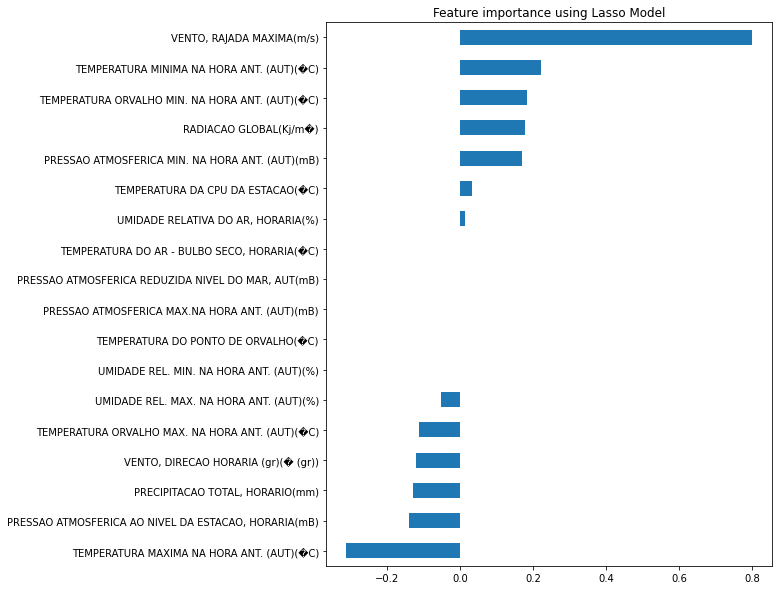

In [6]:
#EMbedded Method
reg = LassoCV()
reg.fit(_x, _y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(_x, _y))
coef = pd.Series(reg.coef_, index = _x.columns)

list_embedded = []
for ind, value in coef.iteritems():
    if value != 0:
        list_embedded.append(ind)
print(list_embedded)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()

mpl.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [7]:
#Boruta
forest = RandomForestRegressor(max_depth = 5, random_state = 42)

boruta_feature_selector = BorutaPy(forest, n_estimators='auto', verbose=0, random_state=4242, max_iter = 100, perc = 75)
boruta_feature_selector.fit(np.array(_x), np.array(_y))

final_features = list()
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(df.columns[x])

final_features

['PRECIPITACAO TOTAL, HORARIO(mm)',
 'RADIACAO GLOBAL(Kj/m�)',
 'VENTO, DIRECAO HORARIA (gr)(� (gr))',
 'VENTO, RAJADA MAXIMA(m/s)']

In [9]:
final_features = ['PRECIPITACAO TOTAL, HORARIO(mm)',
 'RADIACAO GLOBAL(Kj/m�)',
 'VENTO, DIRECAO HORARIA (gr)(� (gr))',
 'VENTO, RAJADA MAXIMA(m/s)']

**Interseção de Features**

In [13]:
backward_elimination_list = set(selected_features_BE)
RFE_list = set(selected_features_rfe)
embedded_method_list = set(list_embedded)
boruta_method_list = set(final_features)

BE_RFE_List = backward_elimination_list.intersection(RFE_list)
EM_BE_RFE_List = BE_RFE_List.intersection(embedded_method_list)
final_feature_list = EM_BE_RFE_List.intersection(boruta_method_list)

final_feature_list = list(final_feature_list)

final_feature_list

['PRECIPITACAO TOTAL, HORARIO(mm)',
 'VENTO, DIRECAO HORARIA (gr)(� (gr))',
 'VENTO, RAJADA MAXIMA(m/s)',
 'RADIACAO GLOBAL(Kj/m�)']

**Horizonte de Previsão de  1 dia**

**Seleção de Hiper-Parâmetros com Algoritmos Genéticos**

In [4]:
from deap import base, creator, tools, algorithms
import random

def mutate(individual):
    gene = random.randint(0,19) #select which parameter to mutate
    if gene == 0:
        if individual[0] == 3:
            individual[0] = random.choice([6, 12, 24])
        elif individual[0] == 6:
            individual[0] = random.choice([3, 12, 24])
        elif individual[0] == 12:
            individual[0] = random.choice([3, 6, 24])
        else:
            individual[0] = random.choice([3, 6, 12])
    elif gene == 1:
        if individual[1] == 'minmax':
            individual[1] = 'standard'
        else:
            individual[1] = 'minmax'
    elif gene == 2:
        if individual[2] == 'numeric':
            individual[2] = random.choice(['1ofN', 'binary'])
        elif individual[2] == '1ofN':
            individual[2] = random.choice(['numeric', 'binary'])
        else:
            individual[2] = random.choice(['numeric', '1ofN'])
        
    elif gene == 3:
        if individual[3] == True:
            individual[3] = False
        else:
            individual[3] = True

    elif gene == 4:
        if individual[4] == True:
            individual[4] = False
        else:
            individual[4] = True
    elif gene == 5:
        individual[5] = random.randint(lower_n_neurons, upper_n_neurons)
    elif gene == 6:
        if individual[6] == 'relu':
            individual[6] = random.choice(['sigmoid', 'selu', 'tanh'])
        elif individual[6] == 'sigmoid':
            individual[6] = random.choice(['relu', 'selu', 'tanh'])
        elif individual[6] == 'selu':
            individual[6] = random.choice(['relu', 'sigmoid', 'tanh'])
        else:
            individual[6] = random.choice(['relu', 'sigmoid', 'selu'])
    elif gene == 7:
        if individual[7] == 1:
            individual[7] = 0
        else:
            individual[7] = 1
    elif gene == 8:
        individual[8] = random.randint(lower_n_neurons, upper_n_neurons)
    
    elif gene == 9:
        if individual[9] == 'relu':
            individual[9] = random.choice(['sigmoid', 'selu', 'tanh'])
        elif individual[9] == 'sigmoid':
            individual[9] = random.choice(['relu', 'selu', 'tanh'])
        elif individual[9] == 'selu':
            individual[9] = random.choice(['relu', 'sigmoid', 'tanh'])
        else:
            individual[9] = random.choice(['relu', 'sigmoid', 'selu'])
    elif gene == 10:
        if individual[10] == 1:
            individual[10] = 0
        else:
            individual[10] = 1
    elif gene == 11:
        individual[11] = random.randint(lower_n_neurons, upper_n_neurons)
    
    elif gene == 12:
        if individual[12] == 'relu':
            individual[12] = random.choice(['sigmoid', 'selu', 'tanh'])
        elif individual[12] == 'sigmoid':
            individual[12] = random.choice(['relu', 'selu', 'tanh'])
        elif individual[12] == 'selu':
            individual[12] = random.choice(['relu', 'sigmoid', 'tanh'])
        else:
            individual[12] = random.choice(['relu', 'sigmoid', 'selu'])

    elif gene == 13:
        if individual[13] == 'linear':
            individual[13] = random.choice(['relu', 'sigmoid'])
        elif individual[13] == 'sigmoid':
            individual[13] = random.choice(['linear', 'relu'])
        else:
            individual[13] = random.choice(['linear', 'sigmoid'])
    
    elif gene == 14:
        individual[14] = random.uniform(lower_lr, upper_lr)
        
    elif gene == 15:
        individual[15] = random.randint(lower_epoch, upper_epoch)
        
    elif gene == 16:
        individual[16] = random.randint(lower_batch_size, upper_batch_size)
        
    return individual,


def evaluate(individual):
    '''
    build and test a model based on the parameters in an individual and return
    the AUROC value
    '''
    # extract the values of the parameters from the individual chromosome
    _lag = individual[0]
    _normalize = individual[1]
    _category = individual[2]
    _month = individual[3]
    _hour = individual[4]
    n_neurons_1 = individual[5]
    _activation_1 = individual[6]
    _hidden_layer_2_active = individual[7]
    n_neurons_2 = individual[8]
    _activation_2 = individual[9]
    _hidden_layer_3_active = individual[10]
    n_neurons_3 = individual[11]
    _activation_3 = individual[12]
    _last_layer_activation = individual[13]
    _lr = individual[14]
    _epoch = individual[15]
    _batch_size = individual[16]
    
    # build the model
    print(f'Train_Lag: {_lag}')
    print(f'Train_Norm: {_normalize}')
    print(f'Train_Category: {_category}')
    print(f'Train_Hour: {_hour}')
    print(f'Train_Month: {_month}')
    X_train, Y_train,_maxtrain, _mintrain, _meantrain, _stdtrain = preparing_data(df_train_micetreated, lag = _lag, normalize = _normalize, category = _category, onlyHour = _hour, onlyMonth = _month)
    X_test, Y_test,_maxtest, _mintest, _meantest, _stdtest = preparing_data(df_test_micetreated,lag = _lag, normalize = _normalize, category = _category, onlyHour = _hour, onlyMonth = _month)
    X_test_day = X_test[-24:].reset_index(drop=True)
    Y_test_day = Y_test[-24:].reset_index(drop=True)
    
    model = Sequential()
    print(f'neurons: {n_neurons_1}')
    print(f'activation: {_activation_1}')

    model.add(Dense(n_neurons_1, input_dim=X_train.shape[1], activation=_activation_1))
    
#     print(f'active: { _hidden_layer_2_active}')
#     if _hidden_layer_2_active == 1:
#         print(f'neurons: {n_neurons_2}')
#         print(f'activation: {_activation_2}')
#         model.add(Dense(n_neurons_2, input_dim=n_neurons_1, activation=_activation_2))

#     print(f'active: { _hidden_layer_3_active}')
#     if _hidden_layer_3_active == 1:
#         print(f'neurons: {n_neurons_3}')
#         print(f'activation: {_activation_3}')
#         model.add(Dense(n_neurons_3, input_dim=n_neurons_2, activation=_activation_3))
        
    print(f'last layer activation: {_last_layer_activation}')
    model.add(Dense(1, activation=_last_layer_activation))
    print(f'learning rate: {_lr}')       
    opt = Adam(lr=_lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error','mean_squared_error'])
    print(f'early stopping épocas:{_epoch}')
    earlyStopping = EarlyStopping(monitor= 'mean_absolute_error', patience=_epoch, verbose=1, restore_best_weights=True)
    print(f'fit épocas: {_epoch}')
    print(f'fit batch size: {_batch_size}')
    model.fit(X_train, Y_train, validation_split=0.2, epochs=_epoch, batch_size=_batch_size,
                          callbacks=[earlyStopping], verbose=0)
    
    testpredict = multistep_prediction(model,X_test_day, _lag)
    
    if _normalize == 'standard':
        orig_y_eval_test = Y_test_day*(_stdtest) + _meantest
        orig_y_hat_test = testpredict*(_stdtest) + _meantest
    else:
        orig_y_eval_test = Y_test_day*(_maxtest - _mintest) + _mintest
        orig_y_hat_test = testpredict*(_maxtest - _mintest) + _mintest


    RMSE_test = (mean_squared_error(orig_y_eval_test, orig_y_hat_test))**0.5
    MAPE_test = MAPE(orig_y_eval_test, orig_y_hat_test)

    print(f'MAPE: {MAPE_test}')
    print(f'RMSE: {RMSE_test}')
    print('------'*20)
    return RMSE_test,

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Maximise the fitness function value
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Possible parameter values
lag_option = [3, 6, 12, 24]
norm = ['minmax', 'standard']
cat = ['numeric', '1ofN', 'binary']
hour = [True, False]
month = [True, False]
lower_n_neurons, upper_n_neurons = 4, 500
active_hidden_layer = [0, 1]
activation = ['relu', 'sigmoid', 'selu', 'tanh']
last_layer_activation = ['linear', 'relu', 'sigmoid']
lower_lr, upper_lr = 0.01, 0.6
lower_epoch, upper_epoch = 100, 1000 
lower_batch_size, upper_batch_size = 24, 240

N_CYCLES = 1

toolbox.register("attr_lag", random.choice, lag_option)
toolbox.register("attr_normalization", random.choice, norm)
toolbox.register("attr_category", random.choice, cat)
toolbox.register("attr_hour", random.choice, hour)
toolbox.register("attr_month", random.choice, month)
toolbox.register("attr_neurons", random.randint, lower_n_neurons, upper_n_neurons)
toolbox.register("attr_hidden_layer_active", random.choice, active_hidden_layer)
toolbox.register("attr_activation", random.choice, activation)
toolbox.register("attr_last_layer_activation", random.choice, last_layer_activation)
toolbox.register("attr_lr", random.uniform, lower_lr, upper_lr)
toolbox.register("attr_epochs", random.randint, lower_epoch, upper_epoch)
toolbox.register("attr_batch_size", random.randint, lower_batch_size, upper_batch_size)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_lag,toolbox.attr_normalization, toolbox.attr_category,
                  toolbox.attr_hour,toolbox.attr_month,toolbox.attr_neurons,toolbox.attr_activation, 
                  toolbox.attr_hidden_layer_active, toolbox.attr_neurons,toolbox.attr_activation,
                  toolbox.attr_hidden_layer_active, toolbox.attr_neurons,toolbox.attr_activation,
                  toolbox.attr_last_layer_activation, toolbox.attr_lr, 
                  toolbox.attr_epochs,toolbox.attr_epochs, toolbox.attr_batch_size), n=N_CYCLES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate",mutate)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("evaluate", evaluate)

population_size = 10
crossover_probability = 0.75
mutation_probability = 0.5
number_of_generations = 25

pop = toolbox.population(n=population_size)
hof_day = tools.HallOfFame(3)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_probability, stats = stats, 
                               mutpb = mutation_probability, ngen=number_of_generations, halloffame=hof_day, 
                               verbose=True) 

day_best_parameters_1 = hof_day[0] # save the optimal set of parameters
day_best_parameters_2 = hof_day[1]
day_best_parameters_3 = hof_day[2]
print(day_best_parameters_1)
print(day_best_parameters_2)
print(day_best_parameters_3)

gen_day = log.select("gen")
max_day = log.select("max")
avg_day = log.select("avg")
min_day = log.select("min")


Train_Lag: 12
Train_Norm: minmax
Train_Category: 1ofN
Train_Hour: False
Train_Month: True
neurons: 215
activation: selu
last layer activation: linear
learning rate: 0.5516624851418458
early stopping épocas:198
fit épocas: 198
fit batch size: 723
MAPE: Output    5.907414e+11
Name: 0, dtype: float64
RMSE: 155507670570.12198
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: numeric
Train_Hour: True
Train_Month: True
neurons: 357
activation: tanh
last layer activation: relu
learning rate: 0.21057541078206676
early stopping épocas:545
fit épocas: 545
fit batch size: 725
MAPE: Output    97.873641
Name: 0, dtype: float64
RMSE: 5.700000000000001
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: binary
Train_Hour: True
Train_Month: False
neurons: 323
activati

neurons: 323
activation: relu
last layer activation: relu
learning rate: 0.10960641902624843
early stopping épocas:500
fit épocas: 500
fit batch size: 201
MAPE: Output    97.873641
Name: 0, dtype: float64
RMSE: 5.700000000000001
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: selu
last layer activation: relu
learning rate: 0.10960641902624843
early stopping épocas:500
fit épocas: 500
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: binary
Train_Hour: True
Train_Month: False
neurons: 323
activation: relu
last layer activation: sigmoid
learning rate: 0.24634945447775503
early stopping épocas

MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: False
neurons: 217
activation: selu
last layer activation: sigmoid
learning rate: 0.24634945447775503
early stopping épocas:828
fit épocas: 828
fit batch size: 538
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: selu
last layer activation: sigmoid
learning rate: 0.24634945447775503
early stopping épocas:828
fit épocas: 828
fit batch size: 538
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
---------------------------------------

neurons: 217
activation: selu
last layer activation: sigmoid
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: binary
Train_Hour: False
Train_Month: False
neurons: 323
activation: relu
last layer activation: sigmoid
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: False
Train_Month: True
neurons: 217
activation: selu
last layer activation: relu
learning rate: 0.10960641902624843
early stopping é

MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 24
Train_Norm: standard
Train_Category: binary
Train_Hour: False
Train_Month: True
neurons: 217
activation: selu
last layer activation: sigmoid
learning rate: 0.5870990888059284
early stopping épocas:828
fit épocas: 828
fit batch size: 538
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: selu
last layer activation: relu
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
----------------------------------------

neurons: 217
activation: selu
last layer activation: sigmoid
learning rate: 0.5870990888059284
early stopping épocas:828
fit épocas: 828
fit batch size: 538
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: selu
last layer activation: sigmoid
learning rate: 0.5870990888059284
early stopping épocas:828
fit épocas: 828
fit batch size: 538
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: binary
Train_Hour: False
Train_Month: True
neurons: 217
activation: selu
last layer activation: sigmoid
learning rate: 0.10960641902624843
early stopping ép

MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: relu
last layer activation: relu
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 350
activation: relu
last layer activation: relu
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
----------------------------------------------

neurons: 449
activation: relu
last layer activation: relu
learning rate: 0.24634945447775503
early stopping épocas:828
fit épocas: 828
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: selu
last layer activation: sigmoid
learning rate: 0.5870990888059284
early stopping épocas:828
fit épocas: 828
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: True
neurons: 217
activation: selu
last layer activation: relu
learning rate: 0.24634945447775503
early stopping épocas:

MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: False
Train_Month: True
neurons: 217
activation: relu
last layer activation: sigmoid
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 538
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: sigmoid
last layer activation: sigmoid
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------

neurons: 350
activation: relu
last layer activation: relu
learning rate: 0.5870990888059284
early stopping épocas:828
fit épocas: 828
fit batch size: 538
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: sigmoid
last layer activation: sigmoid
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
18 	7     	1.97205    	0          	1.97205	1.97205    
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: False
Train_Month: True
neurons: 350
activation: relu
last layer activation: sigmoi

MAPE: Output    28.14865
Name: 0, dtype: float64
RMSE: 1.5567324800098263
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: sigmoid
last layer activation: relu
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 24
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: sigmoid
last layer activation: sigmoid
learning rate: 0.07419487505975449
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------

neurons: 217
activation: sigmoid
last layer activation: relu
learning rate: 0.5870990888059284
early stopping épocas:828
fit épocas: 828
fit batch size: 538
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: False
Train_Month: True
neurons: 350
activation: relu
last layer activation: relu
learning rate: 0.10960641902624843
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
22 	10    	1.96923    	0.00844283 	1.9439 	1.97205    
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: False
neurons: 217
activation: relu
last layer activation: sigmoid


MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: False
Train_Month: False
neurons: 350
activation: relu
last layer activation: sigmoid
learning rate: 0.07419487505975449
early stopping épocas:675
fit épocas: 675
fit batch size: 103
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------------------------------------------------------------------------------------
Train_Lag: 3
Train_Norm: standard
Train_Category: 1ofN
Train_Hour: True
Train_Month: True
neurons: 217
activation: relu
last layer activation: relu
learning rate: 0.5870990888059284
early stopping épocas:828
fit épocas: 828
fit batch size: 538
MAPE: Output    32.868909
Name: 0, dtype: float64
RMSE: 1.972045075904934
------------------------------------------

NameError: name '_daybest_parameters_1' is not defined

In [5]:
print(day_best_parameters_1)

[24, 'standard', '1ofN', True, False, 217, 'relu', 1, 260, 'relu', 1, 320, 'tanh', 'sigmoid', 0.10960641902624843, 675, 103, 124]


In [ ]:
evolution = pd.DataFrame({'Generation': gen_day,
                         'Max RMSE': max_day,
                          'Average':avg_day,
                         'Min RMSE': min_day})

plt.title('Parameter Optimisation')
plt.plot(evolution['Generation'], evolution['Min RMSE'], 'b', color = 'C1',
         label = 'Min')
plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
         label = 'Average')
plt.plot(evolution['Generation'], evolution['Max RMSE'], 'b', color = 'C3',
         label= 'Max')


plt.legend(loc = 'lower right')
plt.ylabel('RMSE - Day Horizon')
plt.xlabel('Generation')
plt.xticks([2,5,10,15,20, 25])

In [ ]:
X_train, Y_train,_maxtrain, _mintrain, _meantrain, _stdtrain = preparing_data(df_train_micetreated, lag = day_best_parameters_1[0], normalize = day_best_parameters_1[1], category = day_best_parameters_1[2], onlyHour= day_best_parameters_1[3], onlyMonth = day_best_parameters_1[4])
X_test, Y_test,_maxtest, _mintest, _meantest, _stdtest = preparing_data(df_test_micetreated, lag = day_best_parameters_1[0], normalize = day_best_parameters_1[1], category = day_best_parameters_1[2], onlyHour= day_best_parameters_1[3], onlyMonth = day_best_parameters_1[4])

In [ ]:
X_test_day = X_test[-24:].reset_index(drop=True)
Y_test_day = Y_test[-24:].reset_index(drop=True)

model = Sequential()
    
model.add(Dense(day_best_parameters_1[5], input_dim=X_train.shape[1], activation=day_best_parameters_1[6]))


model.add(Dense(1, activation=day_best_parameters_1[13]))     
opt = Adam(lr=day_best_parameters_1[14])
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error','mean_squared_error'])

earlyStopping = EarlyStopping(monitor= 'mean_absolute_error', patience=day_best_parameters_1[15], verbose=1, restore_best_weights=True)

model.fit(X_train, Y_train, validation_split=0.2, epochs=day_best_parameters_1[16], batch_size=day_best_parameters_1[17],
                      callbacks=[earlyStopping], verbose=0)

testpredict_day = multistep_prediction(model,X_test_day, day_best_parameters_1[0])

if day_best_parameters_1[1] == 'standard':
        orig_y_eval_test_day = Y_test_day*(_stdtest) + _meantest
        orig_y_hat_test_day = testpredict_day*(_stdtest) + _meantest
    else:
        orig_y_eval_test_day = Y_test_day*(_maxtest - _mintest) + _mintest
        orig_y_hat_test_day = testpredict_day*(_maxtest - _mintest) + _mintest

RMSE_test_day = (mean_squared_error(orig_y_eval_test_day, orig_y_hat_test_day))**0.5
MAPE_test_day = MAPE(orig_y_eval_test_day, orig_y_hat_test_day)

print(f'RMSE: {RMSE_test_day}')
print(f'MAPE: {MAPE_test_day}')

In [ ]:
classification_real_day = mask_classification(orig_y_eval_test_day)
classification_forecasting_day = mask_classification(orig_y_hat_test_day)

print(confusion_matrix(classification_real_day, classification_forecasting_day))
cm_day = confusion_matrix(classification_real_day, classification_forecasting_day)

cmn_day = cm_day.astype('float') / cm_day.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn_day,annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

**Horizonte de Previsão de  1 semana**

**Seleção de Hiper-Parâmetros com Algoritmos Genéticos**

In [ ]:
from deap import base, creator, tools, algorithms
import random

def mutate(individual):
    gene = random.randint(0,19) #select which parameter to mutate
    if gene == 0:
        if individual[0] == 3:
            individual[0] = random.choice([6, 12, 24])
        elif individual[0] == 6:
            individual[0] = random.choice([3, 12, 24])
        elif individual[0] == 12:
            individual[0] = random.choice([3, 6, 24])
        else:
            individual[0] = random.choice([3, 6, 12])
    elif gene == 1:
        if individual[1] == 'minmax':
            individual[1] = 'standard'
        else:
            individual[1] = 'minmax'
    elif gene == 2:
        if individual[2] == 'numeric':
            individual[2] = random.choice(['1ofN', 'binary'])
        elif individual[2] == '1ofN':
            individual[2] = random.choice(['numeric', 'binary'])
        else:
            individual[2] = random.choice(['numeric', '1ofN'])
        
    elif gene == 3:
        if individual[3] == True:
            individual[3] = False
        else:
            individual[3] = True

    elif gene == 4:
        if individual[4] == True:
            individual[4] = False
        else:
            individual[4] = True
    elif gene == 5:
        individual[5] = random.randint(lower_n_neurons, upper_n_neurons)
    elif gene == 6:
        if individual[6] == 'relu':
            individual[6] = random.choice(['sigmoid', 'selu', 'tanh'])
        elif individual[6] == 'sigmoid':
            individual[6] = random.choice(['relu', 'selu', 'tanh'])
        elif individual[6] == 'selu':
            individual[6] = random.choice(['relu', 'sigmoid', 'tanh'])
        else:
            individual[6] = random.choice(['relu', 'sigmoid', 'selu'])
    elif gene == 7:
        if individual[7] == 1:
            individual[7] = 0
        else:
            individual[7] = 1
    elif gene == 8:
        individual[8] = random.randint(lower_n_neurons, upper_n_neurons)
    
    elif gene == 9:
        if individual[9] == 'relu':
            individual[9] = random.choice(['sigmoid', 'selu', 'tanh'])
        elif individual[9] == 'sigmoid':
            individual[9] = random.choice(['relu', 'selu', 'tanh'])
        elif individual[9] == 'selu':
            individual[9] = random.choice(['relu', 'sigmoid', 'tanh'])
        else:
            individual[9] = random.choice(['relu', 'sigmoid', 'selu'])
    elif gene == 10:
        if individual[10] == 1:
            individual[10] = 0
        else:
            individual[10] = 1
    elif gene == 11:
        individual[11] = random.randint(lower_n_neurons, upper_n_neurons)
    
    elif gene == 12:
        if individual[12] == 'relu':
            individual[12] = random.choice(['sigmoid', 'selu', 'tanh'])
        elif individual[12] == 'sigmoid':
            individual[12] = random.choice(['relu', 'selu', 'tanh'])
        elif individual[12] == 'selu':
            individual[12] = random.choice(['relu', 'sigmoid', 'tanh'])
        else:
            individual[12] = random.choice(['relu', 'sigmoid', 'selu'])

    elif gene == 13:
        if individual[13] == 'linear':
            individual[13] = random.choice(['relu', 'sigmoid'])
        elif individual[13] == 'sigmoid':
            individual[13] = random.choice(['linear', 'relu'])
        else:
            individual[13] = random.choice(['linear', 'sigmoid'])
    
    elif gene == 14:
        individual[14] = random.uniform(lower_lr, upper_lr)
        
    elif gene == 15:
        individual[15] = random.randint(lower_epoch, upper_epoch)
        
    elif gene == 16:
        individual[16] = random.randint(lower_batch_size, upper_batch_size)
        
    return individual,


def evaluate(individual):
    '''
    build and test a model based on the parameters in an individual and return
    the AUROC value
    '''
    # extract the values of the parameters from the individual chromosome
    _lag = individual[0]
    _normalize = individual[1]
    _category = individual[2]
    _month = individual[3]
    _hour = individual[4]
    n_neurons_1 = individual[5]
    _activation_1 = individual[6]
    _hidden_layer_2_active = individual[7]
    n_neurons_2 = individual[8]
    _activation_2 = individual[9]
    _hidden_layer_3_active = individual[10]
    n_neurons_3 = individual[11]
    _activation_3 = individual[12]
    _last_layer_activation = individual[13]
    _lr = individual[14]
    _epoch = individual[15]
    _batch_size = individual[16]
    
    # build the model
    print(f'Train_Lag: {_lag}')
    print(f'Train_Norm: {_normalize}')
    print(f'Train_Category: {_category}')
    print(f'Train_Hour: {_hour}')
    print(f'Train_Month: {_month}')
    X_train, Y_train,_maxtrain, _mintrain, _meantrain, _stdtrain = preparing_data(df_train_micetreated, lag = _lag, normalize = _normalize, category = _category, onlyHour = _hour, onlyMonth = _month)
    X_test, Y_test,_maxtest, _mintest, _meantest, _stdtest = preparing_data(df_test_micetreated,lag = _lag, normalize = _normalize, category = _category, onlyHour = _hour, onlyMonth = _month)
    X_test_week = X_test[-168:].reset_index(drop=True)
    Y_test_week = Y_test[-168:].reset_index(drop=True) 
   
    model = Sequential()
    print(f'neurons: {n_neurons_1}')
    print(f'activation: {_activation_1}')

    model.add(Dense(n_neurons_1, input_dim=X_train.shape[1], activation=_activation_1))
    
#     print(f'active: { _hidden_layer_2_active}')
#     if _hidden_layer_2_active == 1:
#         print(f'neurons: {n_neurons_2}')
#         print(f'activation: {_activation_2}')
#         model.add(Dense(n_neurons_2, input_dim=n_neurons_1, activation=_activation_2))

#     print(f'active: { _hidden_layer_3_active}')
#     if _hidden_layer_3_active == 1:
#         print(f'neurons: {n_neurons_3}')
#         print(f'activation: {_activation_3}')
#         model.add(Dense(n_neurons_3, input_dim=n_neurons_2, activation=_activation_3))
        
    print(f'last layer activation: {_last_layer_activation}')
    model.add(Dense(1, activation=_last_layer_activation))
    print(f'learning rate: {_lr}')       
    opt = Adam(lr=_lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error','mean_squared_error'])
    print(f'early stopping épocas:{_epoch}')
    earlyStopping = EarlyStopping(monitor= 'mean_absolute_error', patience=_epoch, verbose=1, restore_best_weights=True)
    print(f'fit épocas: {_epoch}')
    print(f'fit batch size: {_batch_size}')
    model.fit(X_train, Y_train, validation_split=0.2, epochs=_epoch, batch_size=_batch_size,
                          callbacks=[earlyStopping], verbose=0)
    
    testpredict = multistep_prediction(model,X_test_week, _lag)
    
    if _normalize == 'standard':
        orig_y_eval_test = Y_test_week*(_stdtest) + _meantest
        orig_y_hat_test = testpredict*(_stdtest) + _meantest
    else:
        orig_y_eval_test = Y_test_week*(_maxtest - _mintest) + _mintest
        orig_y_hat_test = testpredict*(_maxtest - _mintest) + _mintest


    RMSE_test = (mean_squared_error(orig_y_eval_test, orig_y_hat_test))**0.5
    MAPE_test = MAPE(orig_y_eval_test, orig_y_hat_test)

    print(f'MAPE: {MAPE_test}')
    print(f'RMSE: {RMSE_test}')
    print('------'*20)
    return RMSE_test,

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Maximise the fitness function value
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Possible parameter values
lag_option = [3, 6, 12, 24]
norm = ['minmax', 'standard']
cat = ['numeric', '1ofN', 'binary']
hour = [True, False]
month = [True, False]
lower_n_neurons, upper_n_neurons = 4, 500
active_hidden_layer = [0, 1]
activation = ['relu', 'sigmoid', 'selu', 'tanh']
last_layer_activation = ['linear', 'relu', 'sigmoid']
lower_lr, upper_lr = 0.01, 0.6
lower_epoch, upper_epoch = 100, 1000 
lower_batch_size, upper_batch_size = 24, 240

N_CYCLES = 1

toolbox.register("attr_lag", random.choice, lag_option)
toolbox.register("attr_normalization", random.choice, norm)
toolbox.register("attr_category", random.choice, cat)
toolbox.register("attr_hour", random.choice, hour)
toolbox.register("attr_month", random.choice, month)
toolbox.register("attr_neurons", random.randint, lower_n_neurons, upper_n_neurons)
toolbox.register("attr_hidden_layer_active", random.choice, active_hidden_layer)
toolbox.register("attr_activation", random.choice, activation)
toolbox.register("attr_last_layer_activation", random.choice, last_layer_activation)
toolbox.register("attr_lr", random.uniform, lower_lr, upper_lr)
toolbox.register("attr_epochs", random.randint, lower_epoch, upper_epoch)
toolbox.register("attr_batch_size", random.randint, lower_batch_size, upper_batch_size)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_lag,toolbox.attr_normalization, toolbox.attr_category,
                  toolbox.attr_hour,toolbox.attr_month,toolbox.attr_neurons,toolbox.attr_activation, 
                  toolbox.attr_hidden_layer_active, toolbox.attr_neurons,toolbox.attr_activation,
                  toolbox.attr_hidden_layer_active, toolbox.attr_neurons,toolbox.attr_activation,
                  toolbox.attr_last_layer_activation, toolbox.attr_lr, 
                  toolbox.attr_epochs,toolbox.attr_epochs, toolbox.attr_batch_size), n=N_CYCLES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate",mutate)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("evaluate", evaluate)

population_size = 10
crossover_probability = 0.75
mutation_probability = 0.5
number_of_generations = 50

pop = toolbox.population(n=population_size)
hof_week = tools.HallOfFame(3)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_probability, stats = stats, 
                               mutpb = mutation_probability, ngen=number_of_generations, halloffame=hof_week, 
                               verbose=True) 

week_best_parameters_1 = hof_week[0] # save the optimal set of parameters
week_best_parameters_2 = hof_week[1]
week_best_parameters_3 = hof_week[2]
print(week_best_parameters_1)
print(week_best_parameters_2)
print(week_best_parameters_3)

gen_week = log.select("gen")
max_week = log.select("max")
avg_week = log.select("avg")
min_week = log.select("min")


In [ ]:
evolution = pd.DataFrame({'Generation': gen_week,
                         'Max RMSE': max_week,
                          'Average':avg_week,
                         'Min RMSE': min_week})

plt.title('Parameter Optimisation')
plt.plot(evolution['Generation'], evolution['Min RMSE'], 'b', color = 'C1',
         label = 'Min')
plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
         label = 'Average')
plt.plot(evolution['Generation'], evolution['Max RMSE'], 'b', color = 'C3',
         label= 'Max')


plt.legend(loc = 'lower right')
plt.ylabel('RMSE Week Horizon')
plt.xlabel('Generation')
plt.xticks([2,5,10,15,20, 25])

In [ ]:
X_train, Y_train,_maxtrain, _mintrain, _meantrain, _stdtrain = preparing_data(df_train_micetreated, lag = week_best_parameters_1[0], normalize = week_best_parameters_1[1], category = week_best_parameters_1[2], onlyHour= week_best_parameters_1[3], onlyMonth = week_best_parameters_1[4])
X_test, Y_test,_maxtest, _mintest, _meantest, _stdtest = preparing_data(df_test_micetreated, lag = week_best_parameters_1[0], normalize = week_best_parameters_1[1], category = week_best_parameters_1[2], onlyHour= week_best_parameters_1[3], onlyMonth = week_best_parameters_1[4])

In [ ]:
X_test_week = X_test[-168:].reset_index(drop=True)
Y_test_week = Y_test[-168:].reset_index(drop=True) 

model = Sequential()
    
model.add(Dense(week_best_parameters_1[5], input_dim=X_train.shape[1], activation=week_best_parameters_1[6]))


model.add(Dense(1, activation=week_best_parameters_1[13]))     
opt = Adam(lr=week_best_parameters_1[14])
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error','mean_squared_error'])

earlyStopping = EarlyStopping(monitor= 'mean_absolute_error', patience=week_best_parameters_1[15], verbose=1, restore_best_weights=True)

model.fit(X_train, Y_train, validation_split=0.2, epochs=week_best_parameters_1[16], batch_size=week_best_parameters_1[17],
                      callbacks=[earlyStopping], verbose=0)


testpredict_week = multistep_prediction(model,X_test_week, week_best_parameters_1[0])

if week_best_parameters_1[1] == 'standard':
        orig_y_eval_test_week = Y_test_week*(_stdtest) + _meantest
        orig_y_hat_test_week = testpredict_week*(_stdtest) + _meantest
    else:
        orig_y_eval_test_week = Y_test_week*(_maxtest - _mintest) + _mintest
        orig_y_hat_test_week = testpredict_week*(_maxtest - _mintest) + _mintest

RMSE_test_week = (mean_squared_error(orig_y_eval_test_week, orig_y_hat_test_week))**0.5
MAPE_test_week = MAPE(orig_y_eval_test_week, orig_y_hat_test_week)

print(f'RMSE: {RMSE_test_week}')
print(f'MAPE: {MAPE_test_week}')

In [ ]:
classification_real_week = mask_classification(orig_y_eval_test_week)
classification_forecasting_week = mask_classification(orig_y_hat_test_week)

print(confusion_matrix(classification_real_week, classification_forecasting_week))
cm_week = confusion_matrix(classification_real_week, classification_forecasting_week)

cmn_week = cm_week.astype('float') / cm_week.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn_week,annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')